In [5]:
import warnings
warnings.filterwarnings('ignore')
try:
  import requests
  import pymysql
  import sqlalchemy
  from google.cloud.sql.connector import connector
  from getpass import getpass
except:
  ! python -m pip install pymysql
  ! python -m pip install cloud-sql-python-connector[pg8000]
  ! python -m pip install urllib3
  ! python -m pip install getpass

import os
import pandas as pd
import json
import urllib.request
import requests
import pymysql
import sqlalchemy
from google.cloud.sql.connector import connector
import time
import numpy as np
import collections
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import altair as alt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
import psycopg2.extras

### Postgres DB Connector

In [3]:
# load .json credentials for Google service --- upload .json from downloads local folder to colab instance
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "opensea-333804-f005233a666e.json"

# create connection to database
def getconn() -> pymysql.connections.Connection:
  conn: pymysql.connections.Connection = connector.connect("opensea-333804:us-west1:opensea","pg8000",user="postgres",password="Thor2020!",db="postgres")
  return conn

pool = sqlalchemy.create_engine("postgresql+pg8000://",creator=getconn)

### Event Data Load (Postgres DB)
** only used for generating a list of wallet_addresses to build and test recommender system ** 

In [ ]:
# # load data from postgres tables into dataframe
# df = pd.DataFrame()
# for table_name in ['os_data_event_rb','os_data_event']:
#   data_SQL = "SELECT approved_account,asset_bundle,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_fee_payment_event,dev_seller_fee_basis_points,duration,ending_price,event_type,id,is_private,owner_account,quantity,seller,starting_price,to_account,total_price,transaction,winner_account,listing_time,asset_id,asset_num_sales,asset_background_color,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_animation_url,asset_animation_original_url,asset_name,asset_description,asset_external_link,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_opensea_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_chat_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_medium_username,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_short_description,asset_collection_slug,asset_collection_telegram_url,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_wiki_url,asset_decimals,asset_token_metadata,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_owner_config,asset_token_id,from_account_user_username,from_account_profile_img_url,from_account_address,from_account_config,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price FROM {}".format(table_name)
#   data = []
#   with pool.connect() as db_conn:
#     # get  data from table
#     data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
#     for row in data_payload:
#       data.append(row)

#   col_names = ['approved_account','asset_bundle','auction_type','bid_amount','collection_slug','contract_address','created_date','custom_event_name','dev_fee_payment_event','dev_seller_fee_basis_points','duration','ending_price','event_type','id','is_private','owner_account','quantity','seller','starting_price','to_account','total_price','transaction','winner_account','listing_time','asset_id','asset_num_sales','asset_background_color','asset_image_url','asset_image_preview_url','asset_image_thumbnail_url','asset_image_original_url','asset_animation_url','asset_animation_original_url','asset_name','asset_description','asset_external_link','asset_asset_contract_address','asset_asset_contract_asset_contract_type','asset_asset_contract_created_date','asset_asset_contract_name','asset_asset_contract_nft_version','asset_asset_contract_opensea_version','asset_asset_contract_owner','asset_asset_contract_schema_name','asset_asset_contract_symbol','asset_asset_contract_total_supply','asset_asset_contract_description','asset_asset_contract_external_link','asset_asset_contract_image_url','asset_asset_contract_default_to_fiat','asset_asset_contract_dev_buyer_fee_basis_points','asset_asset_contract_dev_seller_fee_basis_points','asset_asset_contract_only_proxied_transfers','asset_asset_contract_opensea_buyer_fee_basis_points','asset_asset_contract_opensea_seller_fee_basis_points','asset_asset_contract_buyer_fee_basis_points','asset_asset_contract_seller_fee_basis_points','asset_asset_contract_payout_address','asset_permalink','asset_collection_banner_image_url','asset_collection_chat_url','asset_collection_created_date','asset_collection_default_to_fiat','asset_collection_description','asset_collection_dev_buyer_fee_basis_points','asset_collection_dev_seller_fee_basis_points','asset_collection_discord_url','asset_collection_display_data_card_display_style','asset_collection_external_url','asset_collection_featured','asset_collection_featured_image_url','asset_collection_hidden','asset_collection_safelist_request_status','asset_collection_image_url','asset_collection_is_subject_to_whitelist','asset_collection_large_image_url','asset_collection_medium_username','asset_collection_name','asset_collection_only_proxied_transfers','asset_collection_opensea_buyer_fee_basis_points','asset_collection_opensea_seller_fee_basis_points','asset_collection_payout_address','asset_collection_require_email','asset_collection_short_description','asset_collection_slug','asset_collection_telegram_url','asset_collection_twitter_username','asset_collection_instagram_username','asset_collection_wiki_url','asset_decimals','asset_token_metadata','asset_owner_user_username','asset_owner_profile_img_url','asset_owner_address','asset_owner_config','asset_token_id','from_account_user_username','from_account_profile_img_url','from_account_address','from_account_config','payment_token_id','payment_token_symbol','payment_token_address','payment_token_image_url','payment_token_name','payment_token_decimals','payment_token_eth_price','payment_token_usd_price']
#   df_rb = pd.DataFrame(data=data, columns = col_names)
#   df = pd.concat([df,df_rb])
#   time.sleep(30)
# df.shape

In [ ]:
# save data as json file to avoid loading in from PG database each time
# df_json = df.to_json(orient="split")
# with open('json_data_2022_03_04.json', 'w') as outfile:
#     json.dump(df_json, outfile)

# load data from json file to avoid loading from PG database each time
# df = pd.read_json('json_data_2022_03_04.json')

### NFT Wallet Data Load (Postgres DB)
** used to build and test NFT recommender system in DEV **

In [4]:
# load wallet data from PG database
table_name = 'os_wallet_data'
data_SQL = "SELECT * FROM {} WHERE event_type in ('successful','created')".format(table_name)
data = []
with pool.connect() as db_conn:
  # get  data from table
  data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
  for row in data_payload:
    data.append(row)
col_names = ['asset_id', 'asset_num_sales', 'asset_image_url', 'asset_image_preview_url', 'asset_image_thumbnail_url', 'asset_image_original_url', 'asset_name', 'asset_description', 'asset_asset_contract_address', 'asset_asset_contract_asset_contract_type', 'asset_asset_contract_created_date', 'asset_asset_contract_name', 'asset_asset_contract_nft_version', 'asset_asset_contract_owner', 'asset_asset_contract_schema_name', 'asset_asset_contract_symbol', 'asset_asset_contract_total_supply', 'asset_asset_contract_description', 'asset_asset_contract_external_link', 'asset_asset_contract_image_url', 'asset_asset_contract_default_to_fiat', 'asset_asset_contract_dev_buyer_fee_basis_points', 'asset_asset_contract_dev_seller_fee_basis_points', 'asset_asset_contract_only_proxied_transfers', 'asset_asset_contract_opensea_buyer_fee_basis_points', 'asset_asset_contract_opensea_seller_fee_basis_points', 'asset_asset_contract_buyer_fee_basis_points', 'asset_asset_contract_seller_fee_basis_points', 'asset_asset_contract_payout_address', 'asset_permalink', 'asset_collection_banner_image_url', 'asset_collection_created_date', 'asset_collection_default_to_fiat', 'asset_collection_description', 'asset_collection_dev_buyer_fee_basis_points', 'asset_collection_dev_seller_fee_basis_points', 'asset_collection_discord_url', 'asset_collection_display_data_card_display_style', 'asset_collection_external_url', 'asset_collection_featured', 'asset_collection_featured_image_url', 'asset_collection_hidden', 'asset_collection_safelist_request_status', 'asset_collection_image_url', 'asset_collection_is_subject_to_whitelist', 'asset_collection_large_image_url', 'asset_collection_name', 'asset_collection_only_proxied_transfers', 'asset_collection_opensea_buyer_fee_basis_points', 'asset_collection_opensea_seller_fee_basis_points', 'asset_collection_payout_address', 'asset_collection_require_email', 'asset_collection_slug', 'asset_collection_twitter_username', 'asset_collection_instagram_username', 'asset_collection_is_nsfw', 'asset_decimals', 'asset_token_metadata', 'asset_is_nsfw', 'asset_owner_user_username', 'asset_owner_profile_img_url', 'asset_owner_address', 'asset_token_id', 'collection_slug', 'contract_address', 'created_date', 'event_type', 'from_account_user_username', 'from_account_profile_img_url', 'from_account_address', 'id', 'is_private', 'quantity', 'to_account_user_username', 'to_account_profile_img_url', 'to_account_address', 'transaction_block_hash', 'transaction_block_number', 'transaction_from_account_user_username', 'transaction_from_account_profile_img_url', 'transaction_from_account_address', 'transaction_id', 'transaction_timestamp', 'transaction_to_account_profile_img_url', 'transaction_to_account_address', 'transaction_transaction_hash', 'transaction_transaction_index', 'listing_time', 'payment_token_id', 'payment_token_symbol', 'payment_token_address', 'payment_token_image_url', 'payment_token_name', 'payment_token_decimals', 'payment_token_eth_price', 'payment_token_usd_price', 'seller_user_username', 'seller_profile_img_url', 'seller_address', 'wallet_address', 'timestmp']
w_df = pd.DataFrame(data=data, columns = col_names)
# rebuild asset_num_sales from prior str cleaning resulting in decimal replacement with whitespace
w_df['asset_num_sales'].fillna('0', inplace = True)
w_df['asset_num_sales'] = w_df['asset_num_sales'].str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))
# rebuild payment_token_usd_price from prior str cleaning resulting in decimal replacement with whitespace
w_df['payment_token_usd_price'].fillna('0', inplace = True)
w_df['payment_token_usd_price'] = w_df['payment_token_usd_price'].str.replace('None','0').str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))

w_df['token_id_contract_address'] = w_df['asset_token_id'] + w_df['asset_asset_contract_address'] 
print('unique NFTs + contracts in the dataset: {}'.format(w_df['token_id_contract_address'].nunique()))
print('unique wallets in the dataset: {}'.format(w_df['wallet_address'].nunique()))
print('total records in dataset: {}'.format(len(w_df)))

unique NFTs + contracts in the dataset: 149023
unique wallets in the dataset: 2231
total records in dataset: 401745


In [5]:
# randomly sample an NFT wallet
pd.set_option('display.max_columns',250)
w_df[w_df.wallet_address == w_df.wallet_address.sample().values[0]].head(1)

,asset_id,asset_num_sales,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_name,asset_description,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_slug,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_is_nsfw,asset_decimals,asset_token_metadata,asset_is_nsfw,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_token_id,collection_slug,contract_address,created_date,event_type,from_account_user_username,from_account_profile_img_url,from_account_address,id,is_private,quantity,to_account_user_username,to_account_profile_img_url,to_account_address,transaction_block_hash,transaction_block_number,transaction_from_account_user_username,transaction_from_account_profile_img_url,transaction_from_account_address,transaction_id,transaction_timestamp,transaction_to_account_profile_img_url,transaction_to_account_address,transaction_transaction_hash,transaction_transaction_index,listing_time,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price,seller_user_username,seller_profile_img_url,seller_address,wallet_address,timestmp,token_id_contract_address
62390,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,official dormant dragons,0x7f268357a8c2552623316e2562d90e642bb538e5,2022 02 22T04 05 12 095906,successful,nan,nan,nan,3606047645,False,2,nan,nan,nan,0xa08b7d7b62a032ffcc9d1946b2fe5c9f608f5fa346c3...,14253628,Lucky Charm,https storage googleapis com opensea static op...,0x03c6547a6935ec26dc9c9440bbe758afb2e06797,283314080 0,2022 02 22T04 04 56,https storage googleapis com opensea static op...,0x7f268357a8c2552623316e2562d90e642bb538e5,0x8b37464b9d4b2249d2af03fefd280418d1eef9e5bc1b...,260,2022 02 19T06 00 25,nan,ETH,0x0000000000000000000000000000000000000000,https openseauserdata com files 6f8e2979d42818...,Ether,18 0,1 000000000000000,2887,None,https storage googleapis com opensea static op...,0x9322478fe47b1260c58755c249e6db16b0b37c7f,0x03c6547a6935ec26dc9c9440bbe758afb2e06797,2022 03 21 03 16 26 968180,nannan


### NFT Wallet Data Processing & Feature Engineering
** used to build model for classifying wallet type and generating intuition on right number of wallet owner types **

Wallet feature engineering: we hypothesize some combination of these features might enable wallet profiling / clustering to drive a more precise recommender logic based on wallet characterization
- Total unique NFTS held
- Total NFTs purchased, and % of total held
- Total NFTs minted, and % of total held
- Total NFTs sold, and % of total held 
- Count of unique collections held
- Count of the max collection holding
- Count of min collection holding
- Count of mean collection holdering
- Average of NFT volume for NFTs in the wallet
- Median of NFT volume for NFTs in the wallet
- Min of NFT volume for NFTs in the wallet
- Max of NFT volume for NFTs in the wallet

In [6]:
# feature creation / wallet data aggregation (per the above)
total_nft_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_transacted = w_df[w_df.event_type == 'successful'].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_sale = w_df[(w_df.seller_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
unique_collections_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['collection_slug'].nunique()
max_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.max}).reset_index().set_index('wallet_address')
min_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.min}).reset_index().set_index('wallet_address')
avg_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.mean}).reset_index().set_index('wallet_address')
avg_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].mean()
median_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].median()
min_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].min()
max_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].max()
avg_eth_usd_price = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address']).agg({'payment_token_usd_price':np.mean})

In [7]:
# feature dataframe representation
features = {
'total_nft_held':total_nft_held,'total_nft_transacted':total_nft_transacted,
 'total_nft_sale':total_nft_sale,'unique_collections_held':unique_collections_held,
 'max_collection_count':max_collection_count,'min_collection_count':min_collection_count,'avg_collection_count':avg_collection_count,
 'avg_nft_vol':avg_nft_vol,'median_nft_vol':median_nft_vol,'min_nft_vol':min_nft_vol,'max_nft_vol':max_nft_vol,'avg_eth_usd_price':avg_eth_usd_price
}
feature_df = pd.DataFrame(columns=['wallet_address'], data = total_nft_held.index).set_index('wallet_address')

for k,v in features.items():
  try:
    features[k].name = features[k].name.replace(features[k].name,'{}'.format(k))
  except:
    features[k].rename(columns={str(features[k].columns[0]):'{}'.format(k)}, inplace=True)
  feature_df = pd.merge(feature_df,features[k], how='left',left_index=True,right_index=True)

feature_df['total_nft_sale'] = feature_df['total_nft_sale'].fillna(0)
feature_df['nft_churn'] = feature_df['total_nft_transacted'] / feature_df['total_nft_held']
feature_df['nft_sale_pct_transacted'] = feature_df['total_nft_sale'] / feature_df['total_nft_transacted']
feature_df['colletion_spread'] = feature_df['max_collection_count'] - feature_df['min_collection_count']

In [8]:
# Remove high transaction volume wallets as these are indicative of robotic / systemic transactions and therefore unlikely to be good candidates for a recommender system; 
# similar for wallets containing > n number of NFTs

n_transacted = 500
n_held = 500
n_churn = 100 # ratio of transacted / held
feature_df = feature_df[(feature_df['total_nft_transacted'] < n_transacted)&(feature_df['total_nft_held'] < n_held)&(feature_df['nft_churn'] < n_churn)]

### NFT Wallet Exploratory Data Analysis
- Visualize the wallet NFT distributions of the count of NFT transactions, count of NFTs held and unique NFT collections held for insights into global wallet composition
- Analyze relationships between variables to identify relevant characteristics of wallet holders. For example, do wallets with high transaction volumes tend to focus on a particular collection or are they broad-based / diversified?  

In [9]:
feature_df.describe()

,total_nft_held,total_nft_transacted,total_nft_sale,unique_collections_held,max_collection_count,min_collection_count,avg_collection_count,avg_nft_vol,median_nft_vol,min_nft_vol,max_nft_vol,avg_eth_usd_price,nft_churn,nft_sale_pct_transacted,colletion_spread
count,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000
mean,20.940519,45.027961,38.108287,9.512456,5.829181,1.505338,2.440531,1.324740,1.142095,0.504830,3.142857,2740.633070,2.826922,0.938248,4.323843
std,31.717247,66.445610,84.680568,11.937602,10.061373,5.299652,5.559767,0.779571,0.855844,0.741758,1.793633,234.914473,3.915603,4.521505,8.743569
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.027778,0.000000,0.000000
25%,4.000000,7.000000,3.000000,2.000000,2.000000,1.000000,1.142857,0.894737,1.000000,0.000000,2.000000,2580.000000,1.111111,0.317319,0.000000
50%,9.000000,19.000000,13.000000,5.000000,3.000000,1.000000,1.500000,1.266667,1.000000,0.000000,3.000000,2720.000000,1.750000,0.750000,1.000000
75%,23.000000,53.000000,41.000000,12.000000,6.000000,1.000000,2.289409,1.726381,1.500000,1.000000,4.000000,2926.919956,3.000000,1.019676,4.000000
max,263.000000,494.000000,2506.000000,116.000000,191.000000,191.000000,191.000000,7.000000,7.000000,7.000000,11.000000,3103.000000,71.000000,192.769231,110.000000


In [10]:
stdDevs = 3
model_vars = feature_df.copy()
# add upper and lower bounds to df for histogram visualization, based on above std devs param

fields = ['total_nft_transacted','total_nft_held','unique_collections_held']
for field in fields:
  model_vars['{}_lower'.format(field)] = model_vars['{}'.format(field)] - (np.std(model_vars['{}'.format(field)]) * stdDevs)
  model_vars['{}_upper'.format(field)] = model_vars['{}'.format(field)] + (np.std(model_vars['{}'.format(field)]) * stdDevs)

base_chart = alt.Chart(model_vars)
#distribution of total_nfts_transacted with std deviations per above variable
nft_trans_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("total_nft_transacted:Q", bin=alt.Bin(extent=[0, 200], step=50)), y='count()')
trans_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_transacted):Q',title='Total NFTs Transacted (+/- {} Standard Deviations)'.format(stdDevs)))
trans_histogram = nft_trans_bar + trans_mean 
trans_histogram = trans_histogram.properties(width=600,height=560)

# distribution of total_nft_held with std deviations per above variable
nft_held_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("total_nft_held:Q", bin=True), y='count()').interactive()
held_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_held):Q',title="Total NFTs Held (+/- {} Standard Deviations)".format(stdDevs)))
held_histogram = nft_held_bar + held_mean
held_histogram = held_histogram.properties(width=450,height=250)

# distribution of word counts with std deviations per above variable
colls_held_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("unique_collections_held:Q", bin=True), y='count()').interactive()
colls_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(unique_collections_held):Q',title="Unique Collections Held (+/- {} Standard Deviations)".format(stdDevs)))
colls_histogram = colls_held_bar + colls_mean
colls_histogram = colls_histogram.properties(width=450,height=250)

held_mets = alt.vconcat(held_histogram,colls_histogram)
alt.hconcat(trans_histogram,held_mets)

alt.HConcatChart(...)

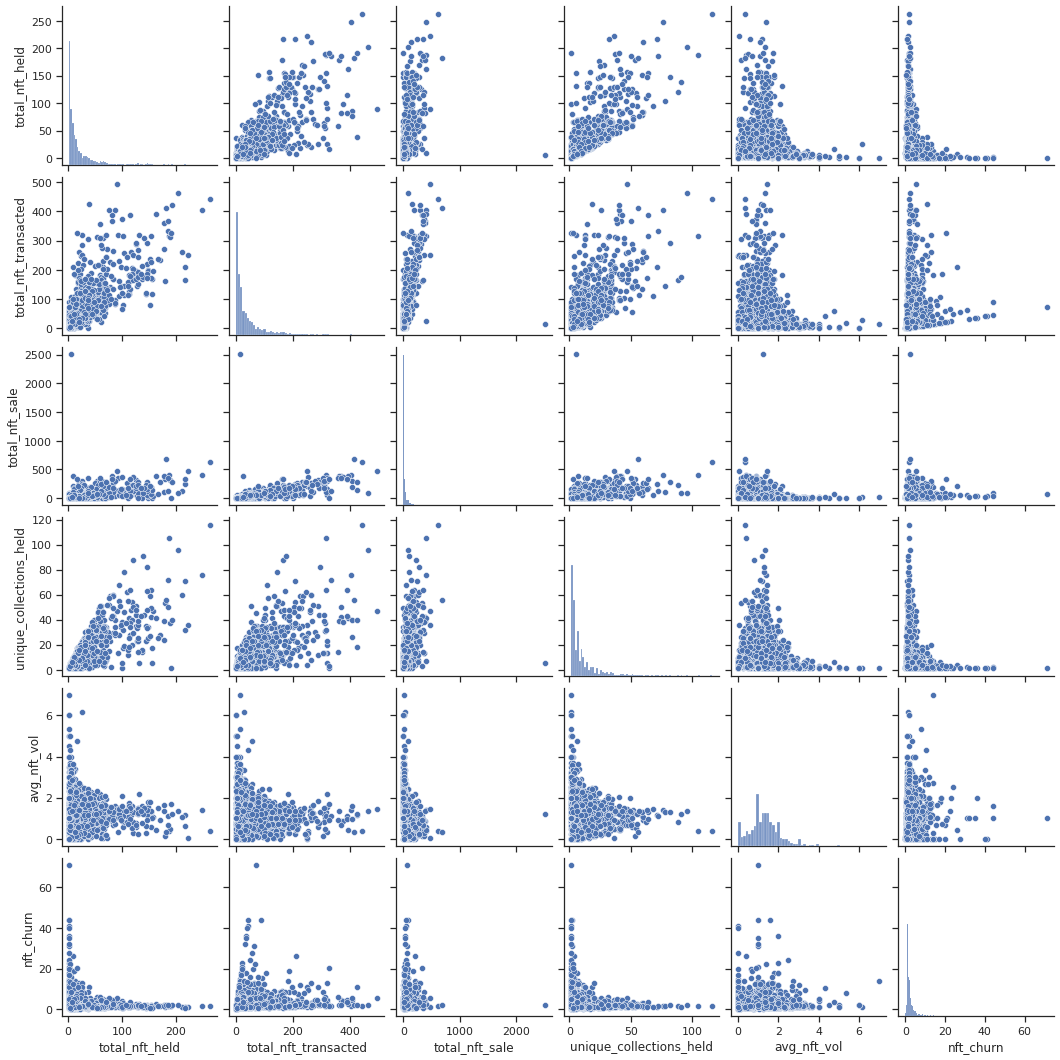

In [ ]:
# view a pair-plot / scatter plot matrix of the wallet features
sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']])

### NFT Wallet Clustering Model (Unsupervised) Build & Evaluation
- k-means model build
- optimal cluster evaluation
- cluster labeling analysis

In [ ]:
X = feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']]

score = [] # Calinski-Harabasz / Davies-Bouldin score -- higher is better
distortions = [] # list to hold distorition scores
inertias = [] # list to hold inertia scores
mapping1 = {}
mapping2 = {}

k_min = 2
k_max = 20

k_space = [np.int(x) for x in np.linspace(k_min, k_max, num= k_max-k_min+1)]
for k in k_space:
    # when running KMeans, set init='k-means++', max_iter=100, n_init=1
    cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
    labels = cla.labels_
    # looking for clusterings that have a high Calinski-Harabasz index, but a low Davies-Bouldin score
    ch_score = calinski_harabasz_score(X.to_numpy(), labels)
    db_score = davies_bouldin_score(X.to_numpy(), labels)
    score.append(ch_score / db_score)
    # elbow method
    distortions.append(sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(cla.inertia_)
    mapping1[k] = sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = cla.inertia_

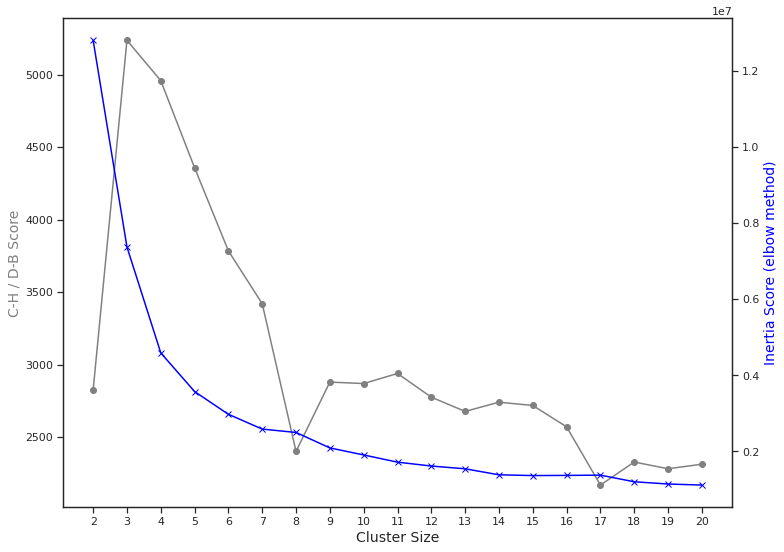

In [ ]:
# visualize the classifier performance for different values of K
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(k_space, score, color="grey", marker="o",)
ax.set_xlabel("Cluster Size",fontsize=14)
ax.set_ylabel("C-H / D-B Score",fontsize=14, color='grey')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(k_space, inertias, color="blue", marker="x")
ax2.set_ylabel("Inertia Score (elbow method)",color="blue",fontsize=14)
plt.xticks(k_space)
plt.show()

In [ ]:
# predict classes for the NFT wallets with k = best k (high C-H index, low D-B score, elbow method for inertia score)
k = 3
cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
feature_df['class_prediction'] = list(cla.predict(X))
feature_df['class_prediction'] = feature_df['class_prediction'].astype(str)

In [ ]:
feature_df.groupby('class_prediction').describe()

total_nft_held                                           \
                          count        mean        std  min   25%    50%   
class_prediction                                                           
0                        1661.0   12.087297  13.398983  1.0   3.0    7.0   
1                         255.0   66.070588  45.088397  6.0  32.0   55.0   
2                          32.0  126.906250  69.763822  6.0  77.0  122.5   

                               total_nft_transacted                         \
                    75%    max                count        mean        std   
class_prediction                                                             
0                  15.0  111.0               1661.0   22.815774  22.742292   
1                  95.0  217.0                255.0  156.988235  65.258148   
2                 183.0  263.0                 32.0  320.531250  93.978029   

                                                    total_nft_sale  \
                   min     25%    50%    75%    max          count   
class_prediction                                                     
0                  1.0    6.00   14.0   34.0  134.0         1661.0   
1                 25.0  109.50  141.0  186.5  462.0          255.0   
2                 13.0  284.25  318.5  387.5  494.0           32.0   

                                                                               \
                        mean         std    min    25%    50%     75%     max   
class_prediction                                                                
0                  16.827815   20.057099    0.0    2.0    9.0   24.00   121.0   
1                 128.835294   59.984548    0.0   87.5  122.0  165.50   394.0   
2                 431.312500  389.342658  280.0  301.5  344.5  390.25  2506.0   

                 unique_collections_held                                    \
                                   count       mean        std  min    25%   
class_prediction                                                             
0                                 1661.0   6.481036   6.558663  1.0   2.00   
1                                  255.0  25.478431  17.098099  1.0  13.00   
2                                   32.0  41.812500  25.485527  3.0  28.75   

                                     max_collection_count             \
                   50%    75%    max                count       mean   
class_prediction                                                       
0                  4.0   9.00   51.0               1661.0   4.069837   
1                 22.0  33.50   96.0                255.0  15.509804   
2                 39.0  50.25  116.0                 32.0  20.843750   

                                                           \
                        std  min  25%   50%    75%    max   
class_prediction                                            
0                  5.284320  1.0  1.0   2.0   4.00   53.0   
1                 20.299696  2.0  5.0   9.0  17.50  191.0   
2                 18.845911  2.0  8.0  15.0  23.25   82.0   

                 min_collection_count                                      \
                                count      mean        std  min  25%  50%   
class_prediction                                                            
0                              1661.0  1.405178   2.351917  1.0  1.0  1.0   
1                               255.0  2.243137  13.437655  1.0  1.0  1.0   
2                                32.0  1.031250   0.176777  1.0  1.0  1.0   

                             avg_collection_count                       \
                  75%    max                count      mean        std   
class_prediction                                                         
0                 1.0   39.0               1661.0  2.125056   2.690094   
1                 1.0  191.0                255.0  4.390756  13.662152   
2                 1.0    2.0                 32.0  3.428976   1.721004   

      

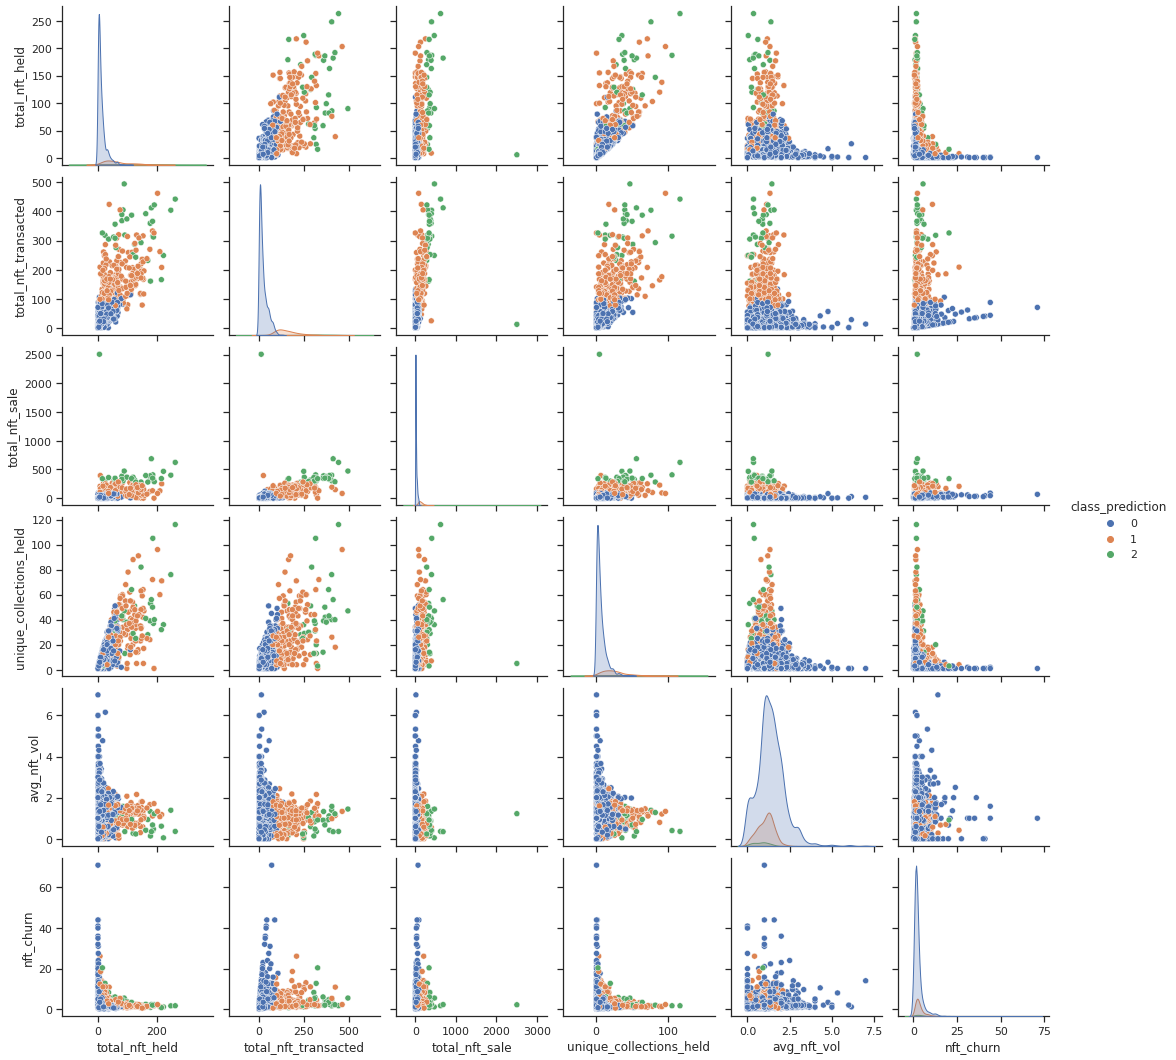

In [ ]:
#sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','class_prediction','nft_churn']], hue='class_prediction')

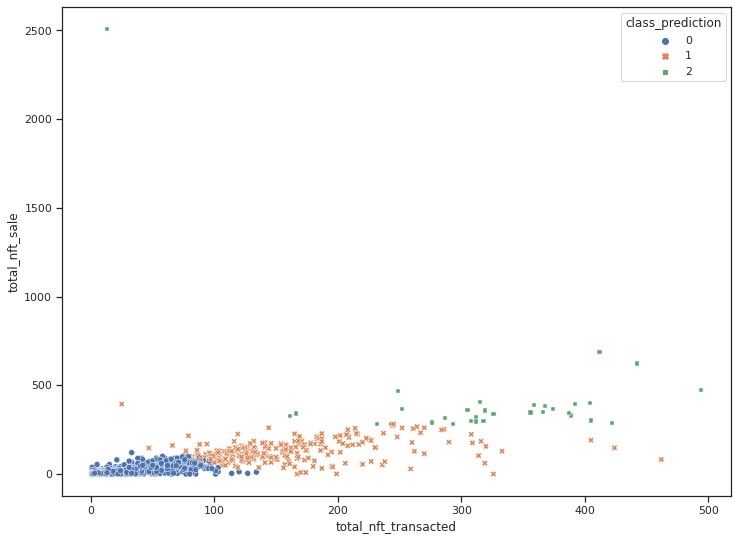

In [ ]:
x = 'total_nft_transacted'
y = 'total_nft_sale'
fig,ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=feature_df, x=x, y=y, hue="class_prediction", style="class_prediction")


### Other Code (placeholder)
- BUILD DATABASE OF OS IMAGES TO TRAIN A CNN

In [ ]:
# # first get the image URL from OS
# # helper func to get the nft asset image url file
# def get_nft_image_url(token_id,asset_contract_address):
#   url = "https://api.opensea.io/api/v1/assets?token_ids={}&order_by=pk&order_direction=desc&asset_contract_address={}&limit=20&include_orders=true".format(token_id,asset_contract_address)
#   headers = {"Accept": "application/json","X-API-KEY": "d4222f42fc6c4a79a3883926a81c4a95"}
#   response = requests.request("GET", url, headers=headers)
#   nft_image_url = dict(response.json())['assets'][0]['image_url']
#   return nft_image_url

# pd.set_option('display.max_rows',250)
# df.iloc[500000].asset_asset_contract_address

# token_id = '93751882162263358060651260285234307757752326041288358141288876844389834424321'
# contract_address = '0x495f947276749ce646f68ac8c248420045cb7b5e'

# get_nft_image_url(token_id,contract_address)


# BUILD DATABASE OF OS NFT IMAGES
# BELOW GENERATES LINKS TO OS IMAGE FOR EACH RECORD IN DATABASE

# # set directory to output folder
# os.chdir('/content/nft_images')
# # get the unique set of nft asset ids and contract addresses
# nft_lookup = list(df[['asset_token_id','asset_asset_contract_address']].to_records(index=False))

# tokens = []
# for nft_record in nft_lookup[0:1000]:  
#   token_id = str(nft_record[0])
#   contract_address = str(nft_record[1])

#   # need to build in a way to assess whether we already have an nft image based on CSV log!
#   # if we do not already have token then append existing log with new images
#   # existing_token_images = pd.read_csv()
#   try:
#     url = get_nft_image_url(token_id,contract_address)
#     urllib.request.urlretrieve("{}".format(url), "{}_{}.jpg".format(token_id,contract_address))
#     tokens.append((token_id,contract_address))
#   except:
#     pass
  
# payload = pd.DataFrame(tokens, columns=['token_id', 'token_contract_address'])
# payload.to_csv('nft_image_payload_20220304.csv',index=False)
# print('stopped at record {}'.format(nft_record))

# zip the images folder for download
# !zip -r /content/nft_images.zip /content/nft_images

# from google.colab import files
# files.download("/content/nft_images.zip")